# Example of usage Spark OCR for Cells Detection and Recognition

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.3.0.spark30.tar.gz

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version\.spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [3]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [4]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.1")

spark

Spark version: 3.0.2
Spark NLP version: 3.0.1
Spark OCR version: 3.3.0



## Read images and display it


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/tableImage/table0.png
    Resolution: 143 dpi
    Width: 1350 px
    Height: 526 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


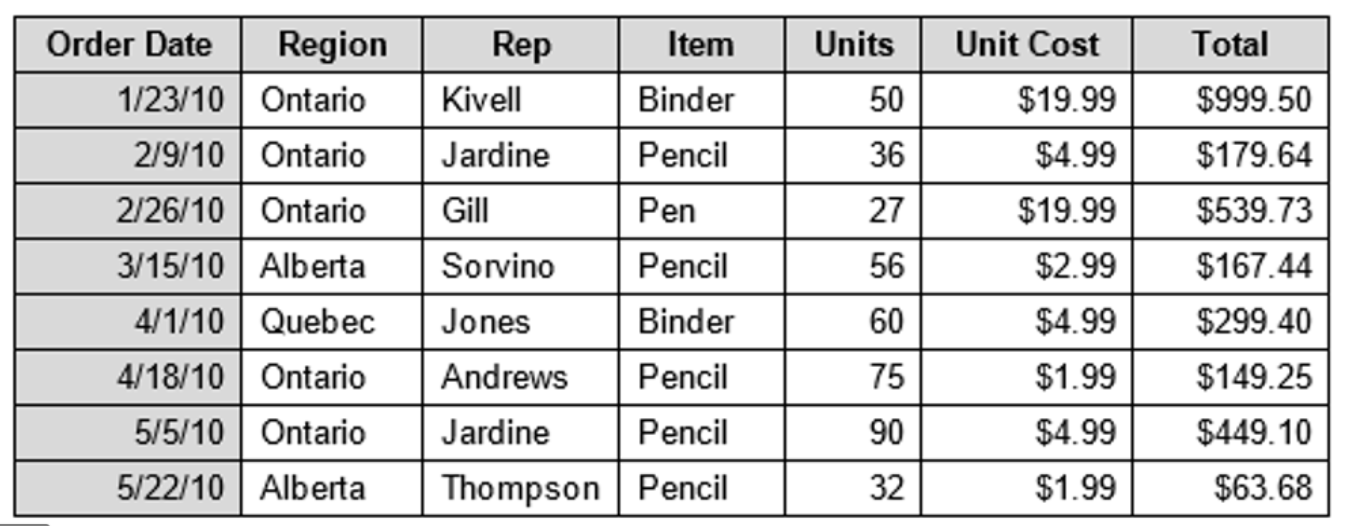


    Image #1:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/tableImage/table1.png
    Resolution: 0 dpi
    Width: 850 px
    Height: 411 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


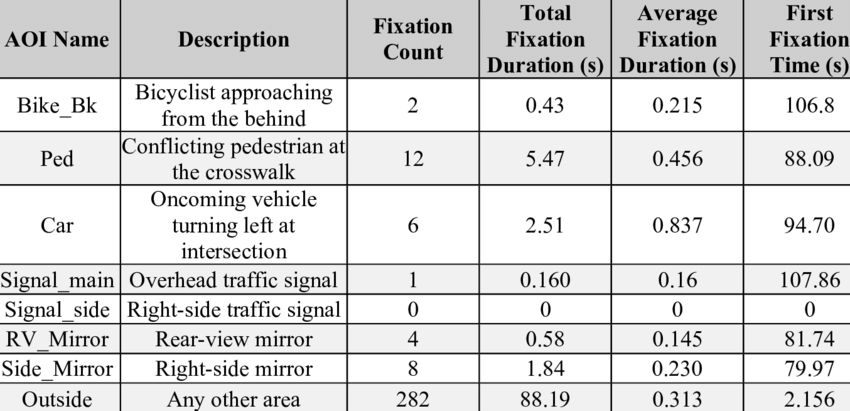

In [8]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/tableImage/*.png')
image_df= spark.read.format("binaryFile").load(test_image_path)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [6]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_BYTE_GRAY)
binary_to_image.setInputCol("content")

cell_detector = TableCellDetector()
cell_detector.setInputCol("image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)

table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(2)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

pipeline = PipelineModel(stages=[
    binary_to_image,
     cell_detector,
     table_recognition
])

## Run pipeline

In [7]:
results = pipeline.transform(image_df).cache()

path_array = f.split(results['path'], '/')

exploded_results = results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .select("table", "filename") \
    .withColumn("cells", f.explode(f.col("table.chunks"))) \
    .select([f.col("filename")] + [f.col("cells")[i].getField("chunkText").alias(f"col{i}") for i in
             range(0, 7)]) \

## Show recognized cells for first image

In [9]:
exploded_results.filter(f.col("filename") == "table0.png") \
    .show(20, False)

+----------+----------+-------+--------+------+-----+---------+-------+
|filename  |col0      |col1   |col2    |col3  |col4 |col5     |col6   |
+----------+----------+-------+--------+------+-----+---------+-------+
|table0.png|Order Date|Region |Rep     |Item  |Units|Unit Cost|Total  |
|table0.png|1/23/10   |Ontario|Kivell  |Binder|50   |$19.99   |$999.50|
|table0.png|2/9/10    |Ontario|Jardine |Pencil|36   |$4.99    |$179.64|
|table0.png|2/26/10   |Ontario|Gill    |Pen   |27   |$19.99   |$539.73|
|table0.png|3/15/10   |Alberta|Sorvino |Pencil|56   |$2.99    |$167.44|
|table0.png|4/1/10    |Quebec |Jones   |Binder|60   |$4.99    |$299.40|
|table0.png|4/18/10   |Ontario|Andrews |Pencil|75   |$1.99    |$149.25|
|table0.png|5/5/10    |Ontario|Jardine |Pencil|90   |$4.99    |$449.10|
|table0.png|5/22/10   |Alberta|Thompson|Pencil|32   |$1.99    |$63.68 |
+----------+----------+-------+--------+------+-----+---------+-------+



## Show recognized cells for second image

In [10]:
exploded_results.filter(f.col("filename") == "table1.png") \
    .show(20, False)

+----------+-----------+-------------------------------------------+-------------+-------------------------+---------------------------+---------------------+----+
|filename  |col0       |col1                                       |col2         |col3                     |col4                       |col5                 |col6|
+----------+-----------+-------------------------------------------+-------------+-------------------------+---------------------------+---------------------+----+
|table1.png|AOI Name   |Description                                |FixationCount|TotalFixationDuration (s)|AverageFixationDuration (s)|FirstFixatiorTime (s)|null|
|table1.png|Bike_Bk    |Bicyclist approachingfrom the behind       |2            |0.43                     |0.215                      |106.8                |null|
|table1.png|Ped        |Conflicting pedestrian atthe crosswalk     |12           |5.47                     |0.456                      |88.09                |null|
|table1.png|Car 